# PFAS Cost-Risk Analysis

## Overview
This notebook analyzes the cost-effectiveness of different PFAS treatment scenarios using UCMR5 data.

## Starting Dataset
- Source: `system_max_with_population` from `Pfas_ucmr5_analysis.ipynb`
- Systems: 9,771 water systems with population data
- Key columns: PWSID, PFOA, PFOS, POPULATION_SERVED_COUNT, population_bin

## Objectives
1. Estimate treatment costs for varying regulatory thresholds (4, 8, 12, 20, 40 ng/L)
2. Calculate risk reduction (ng×person/day) for each scenario
3. Determine the cost-effectiveness of different treatment targets
4. Visualize trade-offs between costs and public health benefits

In [1]:
# Load necessary Python Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Read the data from system_max_with_population file
df = pd.read_csv('system_max_with_population_clean.csv')

In [3]:
df.head()

,PWSID,PFOA,PFOS,exceeds_threshold(0.004*0.8),POPULATION_SERVED_COUNT,population_bin
0,AK2110342,0.0,0.0,False,38526.0,"10,001 - 50,000"
1,AK2110601,0.0,0.0,False,10947.0,"10,001 - 50,000"
2,AK2120232,0.0,0.0,False,8937.0,"3,301 - 10,000"
3,AK2130075,0.0,0.0,False,9448.0,"3,301 - 10,000"
4,AK2210605,0.0,0.0,False,794.0,"501 - 1,000"


In [4]:
df.tail()

,PWSID,PFOA,PFOS,exceeds_threshold(0.004*0.8),POPULATION_SERVED_COUNT,population_bin
9766,WY5601569,0.0,0.0,False,580.0,"501 - 1,000"
9767,WY5680074,0.0,0.0,False,4300.0,"3,301 - 10,000"
9768,WY5680085,0.0,0.0,False,7675.0,"3,301 - 10,000"
9769,WY5680095,0.0,0.0,False,4514.0,"3,301 - 10,000"
9770,WY5680122,0.0,0.0,False,5500.0,"3,301 - 10,000"


In [5]:
df.sample(10)

,PWSID,PFOA,PFOS,exceeds_threshold(0.004*0.8),POPULATION_SERVED_COUNT,population_bin
7436,SC3010002,0.008,0.0081,True,8938.0,"3,301 - 10,000"
9321,WA5340529,0.000,0.0000,False,2760.0,"1,001 - 3,300"
964,CA3010100,0.000,0.0000,False,15948.0,"10,001 - 50,000"
3678,LA1103005,0.000,0.0000,False,10791.0,"10,001 - 50,000"
1718,FL3420074,0.000,0.0056,True,9358.0,"3,301 - 10,000"
83,AL0000279,0.000,0.0000,False,4287.0,"3,301 - 10,000"
4967,MS0450013,0.000,0.0000,False,24459.0,"10,001 - 50,000"
4288,MI0004220,0.000,0.0000,False,12851.0,"10,001 - 50,000"
2477,IL0195150,0.000,0.0000,False,5300.0,"3,301 - 10,000"
2583,IL0314180,0.000,0.0000,False,43212.0,"10,001 - 50,000"


In [6]:
df.query('`exceeds_threshold(0.004*0.8)` == True') 

,PWSID,PFOA,PFOS,exceeds_threshold(0.004*0.8),POPULATION_SERVED_COUNT,population_bin
5,AK2210906,0.0091,0.0000,True,221351.0,"100,001 - 1,000,000"
21,AK2310730,0.0054,0.0000,True,78324.0,"50,001 - 100,000"
22,AK2310900,0.0064,0.0000,True,27000.0,"10,001 - 50,000"
24,AK2320078,0.0000,0.0463,True,4900.0,"3,301 - 10,000"
29,AL0000013,0.0161,0.0202,True,8670.0,"3,301 - 10,000"
...,...,...,...,...,...,...
9734,WV3305405,0.0132,0.0000,True,5674.0,"3,301 - 10,000"
9735,WV3305407,0.0465,0.0000,True,34251.0,"10,001 - 50,000"
9736,WV3305410,0.0058,0.0000,True,7252.0,"3,301 - 10,000"
9738,WV3305412,0.0320,0.0000,True,3469.0,"3,301 - 10,000"


In [7]:
total_systems = len(df)
exceeding_systems = len(df.query('`exceeds_threshold(0.004*0.8)` == True'))
non_exceeding_systems = total_systems - exceeding_systems
percent_exceed = (exceeding_systems / total_systems) * 100

print("=== Exceedance Summary (0.0032 µg/L threshold) ===")
print(f"Total number of systems: {total_systems:,}")
print(f"Systems exceeding threshold: {exceeding_systems:,}")
print(f"Systems NOT exceeding threshold: {non_exceeding_systems:,}")
print(f"Percentage exceeding: {percent_exceed:.2f}%")


=== Exceedance Summary (0.0032 µg/L threshold) ===
Total number of systems: 9,771
Systems exceeding threshold: 1,611
Systems NOT exceeding threshold: 8,160
Percentage exceeding: 16.49%


### PFAS Threshold Exceedance (4–40 ng/L)

Our dataset reports PFOA and PFOS in µg/L, we convert thresholds from ng/L → µg/L:

- 4 ng/L → 0.004 µg/L  
- 8 ng/L → 0.008 µg/L  
- 12 ng/L → 0.012 µg/L  
- 20 ng/L → 0.020 µg/L  
- 40 ng/L → 0.040 µg/L  

We then compute:

`total_pfas = PFOA + PFOS`

For each threshold, we create a column (`exceeds_4`, `exceeds_8`, …) that is True if `PFOA` or `PFOS`  exceeds the converted value.

These columns define which systems would require treatment under different regulatory scenarios.


In [9]:
# create a new column in the df total_pfas adding both the pfas.
df['total_pfas'] = df['PFOA'] + df['PFOS']

In [10]:
thresholds_ng = [4, 8, 12, 20, 40]

for t in thresholds_ng:
    col_name = f"exceeds_{t}"
    threshold_ug = t / 1000   # convert ng/L → µg/L
    df[col_name] = (df['PFOA'] > threshold_ug) | (df['PFOS'] > threshold_ug) #initially i did total pfas > threshold_ug, but now either one

In [13]:
df[['total_pfas', 'PFOA', 'PFOS', 'exceeds_4', 'exceeds_8', 'exceeds_12', 'exceeds_20', 'exceeds_40']].sample(20)

,total_pfas,PFOA,PFOS,exceeds_4,exceeds_8,exceeds_12,exceeds_20,exceeds_40
6719,0.0000,0.00,0.0000,False,False,False,False,False
36,0.0000,0.00,0.0000,False,False,False,False,False
6019,0.0043,0.00,0.0043,True,False,False,False,False
5432,0.0000,0.00,0.0000,False,False,False,False,False
5590,0.0000,0.00,0.0000,False,False,False,False,False
7124,0.0057,0.00,0.0057,True,False,False,False,False
6278,0.0000,0.00,0.0000,False,False,False,False,False
2249,0.0000,0.00,0.0000,False,False,False,False,False
184,0.0000,0.00,0.0000,False,False,False,False,False
9555,0.0000,0.00,0.0000,False,False,False,False,False


In [14]:
print("=== Number of Systems Exceeding Each Threshold ===")
for t in thresholds_ng:
    col = f"exceeds_{t}"
    count = df[col].sum()
    percent = (count / len(df)) * 100
    print(f"{t} ng/L: {count:,} systems ({percent:.2f}%)")

=== Number of Systems Exceeding Each Threshold ===
4 ng/L: 1,583 systems (16.20%)
8 ng/L: 742 systems (7.59%)
12 ng/L: 413 systems (4.23%)
20 ng/L: 177 systems (1.81%)
40 ng/L: 42 systems (0.43%)


### Estimated Flow (MGD)

The flow for each water system is estimated using:

Flow (MGD) = (Population × 109) / 1,000,000

where 109 represents average gallons of water used per person per day, and dividing by 1,000,000 converts gallons/day into million gallons per day (MGD).


In [15]:
df['flow_MGD'] = ((df['POPULATION_SERVED_COUNT']*109)/ 1_000_000)
df[['POPULATION_SERVED_COUNT', 'flow_MGD']].head()

,POPULATION_SERVED_COUNT,flow_MGD
0,38526.0,4.199334
1,10947.0,1.193223
2,8937.0,0.974133
3,9448.0,1.029832
4,794.0,0.086546


### Risk Reduction (ng/person/day)

Risk reduction per person is calculated as:

$$\text{Risk Reduction} = \frac{ (\text{PFOA} + \text{PFOS}) \times \text{Flow Rate} \times 3,780 }{ \text{Population Served} }$$

where **3780** is the unit conversion factor.


In [17]:
df['risk_reduction'] = (
    df['total_pfas'] *
    df['flow_MGD'] *
    3780 /
    df['POPULATION_SERVED_COUNT']
)

df[['total_pfas', 'flow_MGD', 'POPULATION_SERVED_COUNT', 'risk_reduction']].sample(20)

,total_pfas,flow_MGD,POPULATION_SERVED_COUNT,risk_reduction
5840,0.0000,0.684084,6276.0,0.000000
2980,0.0000,0.479055,4395.0,0.000000
924,0.0000,0.319370,2930.0,0.000000
5207,0.0265,2.994448,27472.0,0.010919
9408,0.0000,6.546976,60064.0,0.000000
8848,0.0000,0.911022,8358.0,0.000000
5932,0.0000,0.981000,9000.0,0.000000
6393,0.0000,1.285873,11797.0,0.000000
3262,0.0000,1.310398,12022.0,0.000000
6009,0.0000,23.326000,214000.0,0.000000


In [22]:
df['population_bin'] = df['population_bin'].replace({'25 to 100': '25 - 100'})

In [23]:
# mapping population bin with facility annualized cost column of Table 4 in the Corona memo

popbin_cost_map = {
    '25 - 100': 0.07,
    '101 - 500': 0.12,
    '501 - 1,000': 0.17,
    '1,001 - 3,300': 0.25,
    '3,301 - 10,000': 0.40,
    '10,001 - 50,000': 0.76,
    '50,001 - 100,000': 1.29,
    '100,001 - 1,000,000': 2.33,
    '> 1,000,000': 4.76
}

df['annualized_cost_M'] = df['population_bin'].map(popbin_cost_map)
df[['population_bin', 'annualized_cost_M']].head(10)

,population_bin,annualized_cost_M
0,"10,001 - 50,000",0.76
1,"10,001 - 50,000",0.76
2,"3,301 - 10,000",0.40
3,"3,301 - 10,000",0.40
4,"501 - 1,000",0.17
5,"100,001 - 1,000,000",2.33
6,"10,001 - 50,000",0.76
7,"10,001 - 50,000",0.76
8,25 - 100,0.07
9,"10,001 - 50,000",0.76


In [24]:
# sum up  total national treatment costs for each of 4, 8, 12, 20, 40 scenarios
national_treatment_costs = {}

for t in thresholds_ng:
    col = f"exceeds_{t}"
    # For each system: cost * 1 if it exceeds the threshold, else cost * 0.
    # Summing these values gives the total national treatment cost for that threshold.
    total_cost_M = (df['annualized_cost_M'] * df[col]).sum()  
    national_treatment_costs[t] = round(float(total_cost_M), 2)

national_treatment_costs

{4: 1334.92, 8: 644.97, 12: 364.64, 20: 169.35, 40: 37.7}

### National Annualized Cost Results

Using the population-bin specific annualized cost values from the Corona (Black & Veatch)
technical memo, the total national annualized cost for each PFAS regulatory scenario is:

| Threshold (ng/L) | National Cost ($M) |
|------------------|--------------------|
| 4 ng/L           | 1334.29            |
| 8 ng/L           | 644.69             |
| 12 ng/L          | 364.57             |
| 20 ng/L          | 169.28             |
| 40 ng/L          | 37.63              |


### Total National Risk Reduction (ng·person/day)

For each PFAS threshold (4, 8, 12, 20, 40 ng/L), total national risk reduction is
computed as:

$$\text{Total Risk Reduction}_T = \sum (\text{risk\_reduction} \times \text{exceeds}_T)$$

This represents the nationwide reduction in PFAS exposure for all systems that would
require treatment under threshold **T**.


In [25]:
national_risk = {}

for t in thresholds_ng:
    col = f"exceeds_{t}"
    total_risk = (df['risk_reduction'] * df[col]).sum()
    national_risk[t] = round(float(total_risk), 2)

national_risk


{4: 10.48, 8: 7.9, 12: 5.91, 20: 3.76, 40: 1.68}

### Cost-Effectiveness

Cost-effectiveness for each PFAS threshold is calculated as:

$$\text{Cost-Effectiveness}_T = \frac{ \text{Total Annualized Cost}_T \times 365 }{ \text{Total Risk Reduction}_T }$$

This represents the dollars spent per unit reduction in population PFAS exposure
(ng·person/day).


In [26]:
cost_effectiveness = {}

for t in thresholds_ng:
    total_cost_M = national_treatment_costs[t]          # millions of dollars
    total_risk = national_risk[t]             # ng·person/day

    # convert cost from $M to $, multiply by 365 for annual basis
    ce = (total_cost_M * 1_000_000 * 365) / total_risk

    cost_effectiveness[t] = ce

cost_effectiveness


{4: 46492919847.32824,
 8: 29799246835.443035,
 12: 22520067681.895092,
 20: 16439561170.212767,
 40: 8190773809.523809}

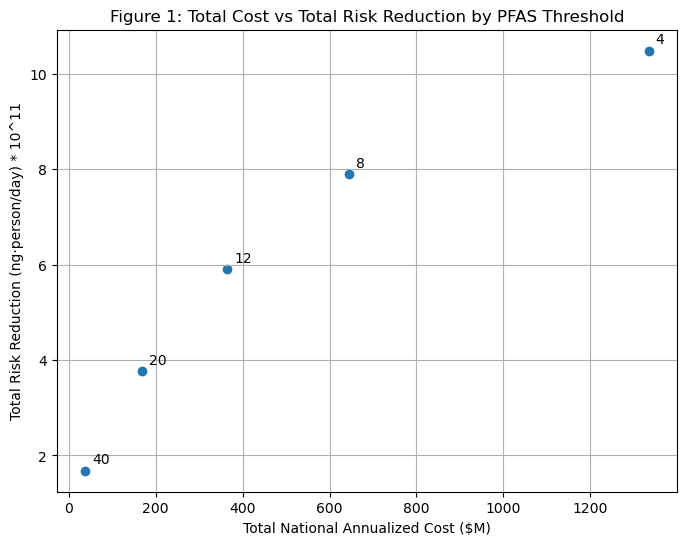

In [36]:
plt.figure(figsize=(8,6))
plt.scatter(costs, risks)

# Label each point with its threshold (4,8,12,20,40)
for t, x, y in zip(thresholds_ng, costs, risks):
    plt.annotate(str(t),
                 (x, y),
                 textcoords="offset points",
                 xytext=(5,5))

plt.xlabel("Total National Annualized Cost ($M)")
plt.ylabel("Total Risk Reduction (ng·person/day) * 10^11")
plt.title("Figure 1: Total Cost vs Total Risk Reduction by PFAS Threshold")
plt.grid(True)
plt.show()


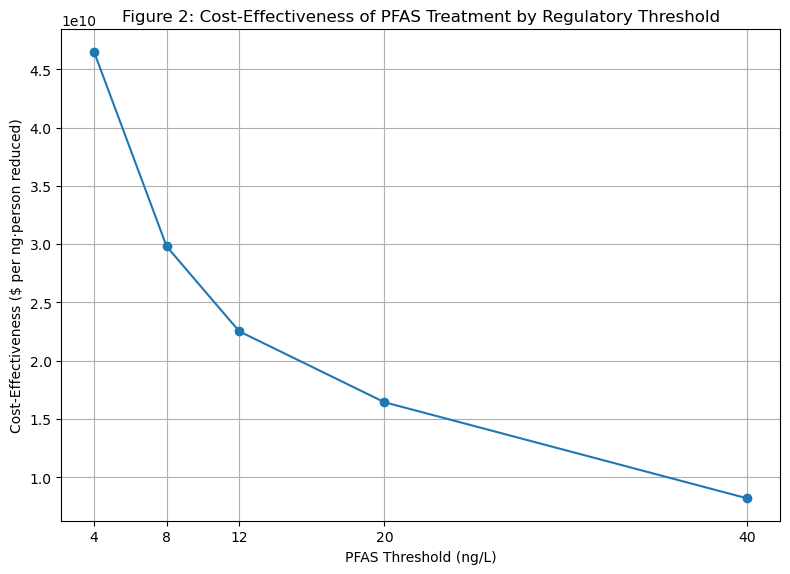

In [37]:
ce_values = [cost_effectiveness[t] for t in thresholds_ng]

plt.figure(figsize=(8,6))
plt.plot(thresholds_ng, ce_values, marker='o')

plt.xticks(thresholds_ng)

plt.xlabel("PFAS Threshold (ng/L)")
plt.ylabel("Cost-Effectiveness ($ per ng·person reduced)")
plt.title("Figure 2: Cost-Effectiveness of PFAS Treatment by Regulatory Threshold")
plt.grid(True)
plt.tight_layout()
plt.show()


In [38]:
cols = [f"exceeds_{t}" for t in thresholds_ng]
exceed_by_bin = df.groupby("population_bin")[cols].mean() * 100
exceed_by_bin

,exceeds_4,exceeds_8,exceeds_12,exceeds_20,exceeds_40
population_bin,,,,,
"1,001 - 3,300",10.629067,4.338395,2.386117,1.518438,0.216920
"10,001 - 50,000",19.712526,8.741566,4.722793,2.082722,0.469346
"100,001 - 1,000,000",33.920705,18.502203,11.013216,5.947137,1.541850
101 - 500,10.091743,6.422018,3.669725,1.834862,1.834862
25 - 100,12.000000,5.333333,1.333333,1.333333,1.333333
"3,301 - 10,000",11.463964,5.495495,3.063063,1.036036,0.270270
"50,001 - 100,000",27.351916,13.414634,7.839721,3.658537,0.522648
"501 - 1,000",5.829596,1.793722,1.345291,0.448430,0.000000
"> 1,000,000",34.615385,15.384615,7.692308,3.846154,0.000000


In [39]:
ordered_bins = [
    "25 - 100",
    "101 - 500",
    "501 - 1,000",
    "1,001 - 3,300",
    "3,301 - 10,000",
    "10,001 - 50,000",
    "50,001 - 100,000",
    "100,001 - 1,000,000",
    "> 1,000,000"
]
exceed_by_bin = exceed_by_bin.reindex(ordered_bins)

<Figure size 1200x700 with 0 Axes>

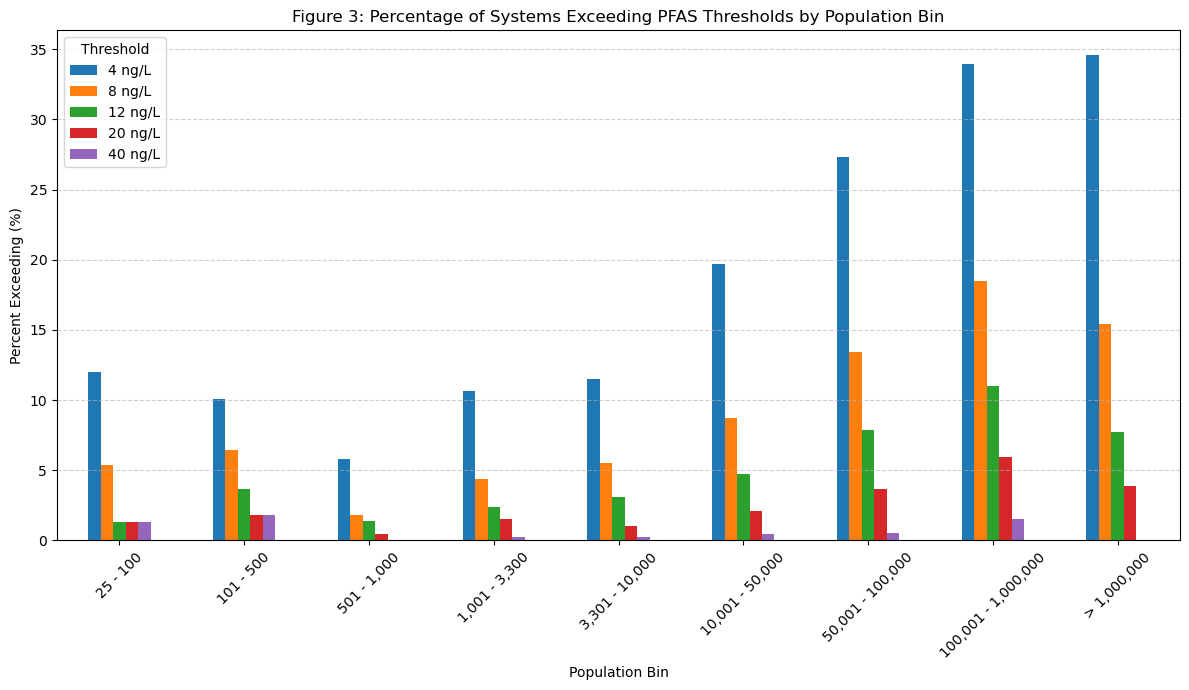

In [40]:
plt.figure(figsize=(12,7))
exceed_by_bin.plot(kind='bar', figsize=(12,7))

plt.title("Figure 3: Percentage of Systems Exceeding PFAS Thresholds by Population Bin")
plt.xlabel("Population Bin")
plt.ylabel("Percent Exceeding (%)")
plt.legend([f"{t} ng/L" for t in thresholds_ng], title="Threshold")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()

plt.show()


Power law fit: y = 2.571e-01 * x^0.523


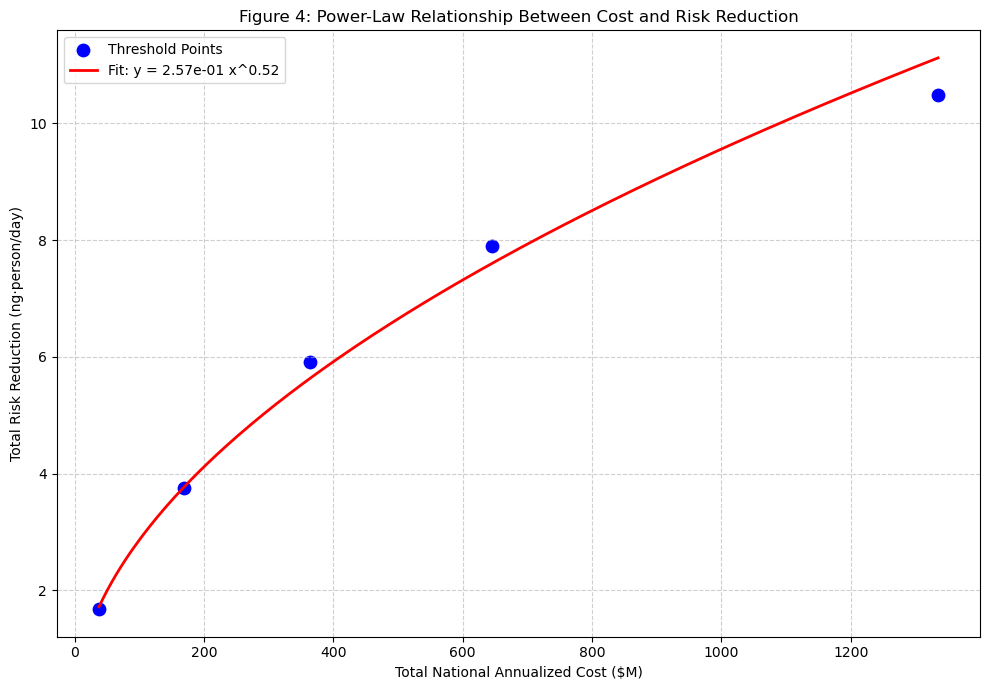

In [41]:
x = list(national_treatment_costs.values())   # total cost (M$)
y = list(national_risk.values())              # total risk reduction (ng·person/day)

# Convert to arrays
x_vals = np.array(x)
y_vals = np.array(y)

# --- Fit the power law y = m * x^b ---
# Transform to log-log space: log(y) = log(m) + b*log(x)
log_x = np.log(x_vals)
log_y = np.log(y_vals)

# Fit linear regression in log space
b, log_m = np.polyfit(log_x, log_y, 1)
m = np.exp(log_m)

print(f"Power law fit: y = {m:.3e} * x^{b:.3f}")

# Generate smooth curve
x_fit = np.linspace(x_vals.min(), x_vals.max(), 200)
y_fit = m * x_fit**b

# --- Plot ---
plt.figure(figsize=(10, 7))
plt.scatter(x_vals, y_vals, color='blue', s=80, label="Threshold Points")
plt.plot(x_fit, y_fit, color='red', linewidth=2, label=f"Fit: y = {m:.2e} x^{b:.2f}")

plt.xlabel("Total National Annualized Cost ($M)")
plt.ylabel("Total Risk Reduction (ng·person/day)")
plt.title("Figure 4: Power-Law Relationship Between Cost and Risk Reduction")
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()